In [35]:
import pandas as pd


df = pd.read_csv("IMDB Dataset.csv")
df = df.head(10)
df.to_csv("IMDB Dataset.csv", index=False)

In [17]:
import pandas as pd


df = pd.read_csv("IMDB Dataset.csv")
df = df.head(1000)
df.to_csv("IMDB Dataset.csv", index=False)

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Загрузка BERT и токенизатора

In [19]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Подготовка данных

In [20]:
df = pd.read_csv("IMDB Dataset.csv")
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})

# Функция кодирования отзывов

In [21]:
def encode_reviews(reviews, max_length):
    return tokenizer.batch_encode_plus(reviews, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")

# Кодирование данных

In [22]:
encoded_data = encode_reviews(df["review"].tolist(), 256)
input_ids = encoded_data["input_ids"]
attention_masks = encoded_data["attention_mask"]
labels = torch.tensor(df["label"].tolist())

# Разделение данных на тренировочные и тестовые

In [23]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Создание загрузчиков данных

In [24]:
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

# Обучение классификатора

In [25]:
import time
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=1e-5)

train_losses = []
test_accuracies = []

pbar = tqdm(total=3, desc="Эпохи")  # Инициализация tqdm
last_update_time = time.time()

for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # обновление прогресса раз в 30 секунд
        current_time = time.time()
        if current_time - last_update_time > 30:
            pbar.set_postfix({"Потери при обучении": total_loss / (batch[0].shape[0] * (epoch + 1)), "Текущая эпоха": epoch + 1})
            pbar.refresh()
            last_update_time = current_time

    train_losses.append(total_loss / len(train_dataloader))

    # Оценка модели после каждой эпохи на тестовых данных
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    for batch in test_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)

        logits = outputs[0]
        _, preds = torch.max(logits, 1)
        correct_predictions += (preds == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

    test_accuracy = correct_predictions / total_predictions
    test_accuracies.append(test_accuracy)
    print(f"Эпоха {epoch+1}/{3}, Потери при обучении: {train_losses[-1]:.4f}, Точность на тестовых данных: {test_accuracy:.4f}")

    pbar.set_postfix({"Потери при обучении": train_losses[-1], "Точность на тестовых данных": test_accuracy})
    pbar.update(1)  # Обновление индикатора прогресса

pbar.close()


D:\data\innopolis\innopolis_labs_part2\lr20_BERT\venv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Эпохи:  33%|███▎      | 1/3 [09:32<19:05, 572.59s/it, Потери при обучении=0.678, Точность на тестовых данных=0.765]

Эпоха 1/3, Потери при обучении: 0.6776, Точность на тестовых данных: 0.7650


Эпохи:  67%|██████▋   | 2/3 [19:49<09:58, 598.80s/it, Потери при обучении=0.506, Точность на тестовых данных=0.86] 

Эпоха 2/3, Потери при обучении: 0.5062, Точность на тестовых данных: 0.8600


Эпохи: 100%|██████████| 3/3 [30:13<00:00, 604.41s/it, Потери при обучении=0.309, Точность на тестовых данных=0.85]

Эпоха 3/3, Потери при обучении: 0.3094, Точность на тестовых данных: 0.8500


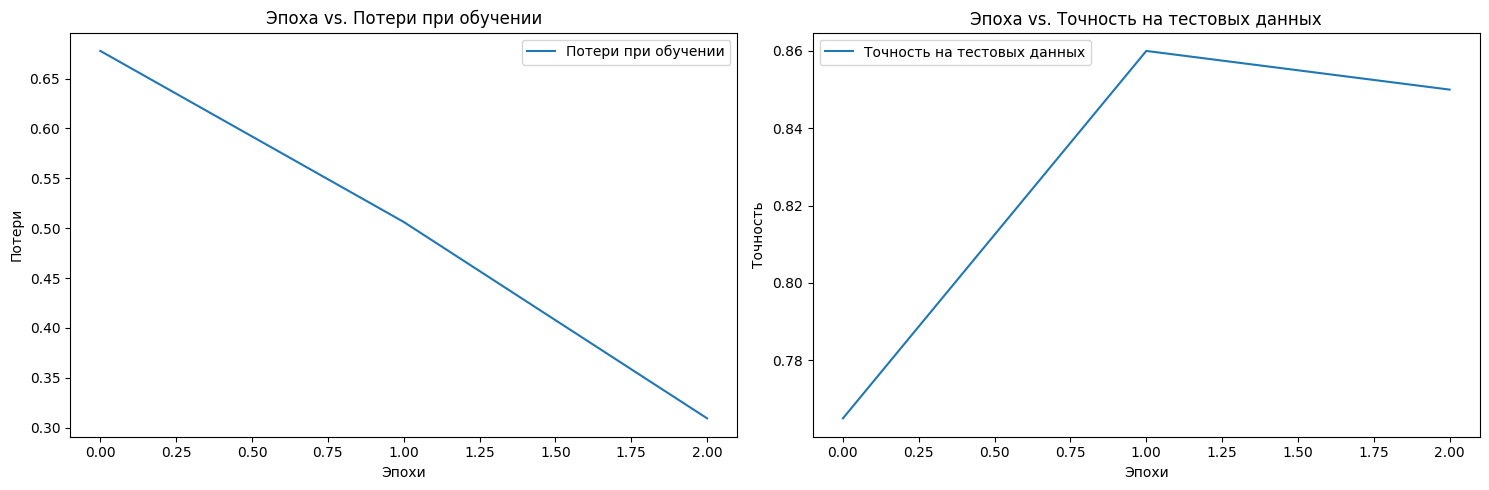

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Потери при обучении")
plt.title("Эпоха vs. Потери при обучении")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Точность на тестовых данных")
plt.title("Эпоха vs. Точность на тестовых данных")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend()

plt.tight_layout()
plt.show()

# Оценка классификатора на всех тестовых данных

In [27]:
predictions, true_labels = [], []
for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_mask = batch[1].to(device)
    batch_labels = batch[2]

    with torch.no_grad():
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.numpy()
    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

print(classification_report(true_labels, predictions, target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.93      0.77      0.84       103
    positive       0.79      0.94      0.86        97

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200

